# CSCA 5632 Unsupervised Algorithms in Machine Learning Final Project


In [1]:
from pathlib import Path
import kagglehub
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import MultiLabelBinarizer

drive = Path("/content/drive/MyDrive")
drive_data = drive / "UCB_USL_final_data"

## Recipes with cuisine categorization

https://www.kaggle.com/datasets/prajwaldongre/collection-of-recipes-around-the-world

161 recipes, 24 cuisines

`[recipe { ingredients, cuisine }]` -> `[cuisine { ingredients }]`

In [2]:
# load data from Kaggle

dir = kagglehub.dataset_download("prajwaldongre/collection-of-recipes-around-the-world")
dir = Path(dir)
cuisine_df = pd.read_csv(dir / "Receipes from around the world.csv", encoding='latin-1')

print(cuisine_df.shape)
cuisine_df.head()

100%|██████████| 9.43k/9.43k [00:00<00:00, 18.5MB/s]

Extracting files...
(161, 8)


,recipe_name,cuisine,ingredients,cooking_time_minutes,prep_time_minutes,servings,calories_per_serving,dietary_restrictions
0,Spicy Kimchi Fried Rice,Korean,"['Cooked rice', 'Kimchi', 'Gochujang', 'Soy sa...",25,15,2.0,450.0,['vegetarian']
1,Classic Margherita Pizza,Italian,"['Pizza dough', 'Tomato sauce', 'Fresh mozzare...",20,30,4.0,350.0,['vegetarian']
2,Coconut Chickpea Curry,Indian,"['Chickpeas', 'Coconut milk', 'Onion', 'Ginger...",35,15,4.0,480.0,"['vegan', 'vegetarian', 'gluten-free', 'dairy-..."
3,Pad See Ew with Tofu,Thai,"['Wide rice noodles', 'Tofu', 'Chinese broccol...",20,10,2.0,520.0,['vegetarian']
4,Beef Bourguignon,French,"['Beef chuck', 'Red wine', 'Bacon', 'Onion', '...",150,30,6.0,680.0,['nan']


In [3]:
# drop columns we don't need

cuisine_df.drop(columns=[
    "cooking_time_minutes",
    "prep_time_minutes",
    "servings",
    "calories_per_serving",
    "dietary_restrictions",
    ], inplace=True)

cuisine_df.head()

,recipe_name,cuisine,ingredients
0,Spicy Kimchi Fried Rice,Korean,"['Cooked rice', 'Kimchi', 'Gochujang', 'Soy sa..."
1,Classic Margherita Pizza,Italian,"['Pizza dough', 'Tomato sauce', 'Fresh mozzare..."
2,Coconut Chickpea Curry,Indian,"['Chickpeas', 'Coconut milk', 'Onion', 'Ginger..."
3,Pad See Ew with Tofu,Thai,"['Wide rice noodles', 'Tofu', 'Chinese broccol..."
4,Beef Bourguignon,French,"['Beef chuck', 'Red wine', 'Bacon', 'Onion', '..."


In [4]:
# cuisines & recipe counts

with pd.option_context('display.max_rows', 10):
  print(cuisine_df['cuisine'].value_counts())

cuisine
Argentinian    12
Swedish        10
Nigerian        9
Japanese        9
Ethiopian       8
               ..
Moroccan        5
Irish           5
Lebanese        5
Indian          1
Chinese         1
Name: count, Length: 24, dtype: int64


In [5]:
# get sets of ingredients by cuisine

def remove_non_alpha(text):
  return "".join(char if (char.isalpha() or char == ',') else ' ' for char in text)

def normalize_whitespace(text):
  return " ".join(text.split())

cuisines = {}

for (name, raw) in zip(cuisine_df['cuisine'], cuisine_df['ingredients']):
  raw = raw.lower()
  raw = re.sub(r'\([^)]*\)', '', raw)  # remove notes in parentheses (e.g. "(optional)", "(cubed)", ...)
  raw = remove_non_alpha(raw)
  raw = normalize_whitespace(raw)

  if name not in cuisines:
    cuisines[name] = set()

  ingredients = raw.split(' , ')
  for ingredient in ingredients:
    # split substitutions (e.g. "beef or lamb")
    for x in ingredient.split(' or '):
      cuisines[name].add(x)

for cuisine in cuisines:
  cuisines[cuisine] = list(cuisines[cuisine])

print('Italian', cuisines['Italian'][:5])
print('Korean', cuisines['Korean'][:5])

Italian ['fresh basil', 'espresso', 'chicken broth', 'guanciale', 'butter']
Korean ['mushrooms', 'beef sirloin', 'cucumber', 'pork belly', 'scallions']


In [6]:
# turn the dictionary into:
# - list of cuisine names
# - list of lists of ingredients used

cuisine_list = []
ingredients_list = []

for cuisine in cuisines:
  cuisine_list.append(cuisine)
  ingredients_list.append(cuisines[cuisine])

print(len(cuisine_list), len(ingredients_list))

# process into matrix

mlb = MultiLabelBinarizer()
cuisines_matrix = mlb.fit_transform(ingredients_list)

print(len(mlb.classes_))
print(cuisines_matrix.shape)
print(mlb.classes_[:10])

24 24
401
(24, 401)
['ackee' 'aji amarillo' 'aji amarillo paste' 'aji amarillo peppers'
 'aji limo pepper' 'allspice' 'almond paste' 'almonds' 'anchovy broth'
 'andouille sausage']


In [7]:
# construct DataFrame of the ingredients used in the cuisines

ingredients_df = pd.DataFrame(cuisines_matrix, columns=mlb.classes_)
ingredients_df.index = cuisine_list

ingredients_df = ingredients_df.astype(pd.SparseDtype("bool", False))
print(ingredients_df.shape)
ingredients_df.head()

(24, 401)


,ackee,aji amarillo,aji amarillo paste,aji amarillo peppers,aji limo pepper,allspice,almond paste,almonds,anchovy broth,andouille sausage,...,white pepper,white wine,white wine vinegar,wide rice noodles,worcestershire sauce,yams,yeast,yellow split peas,za atar spice blend,zucchini
Korean,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
Italian,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
Indian,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Thai,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
French,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [8]:
# check the DataFrame

print(cuisine_list[0])
print(sorted(ingredients_list[0]))

row = ingredients_df.iloc[0]
print(row[row == True].index.tolist())

Korean
['anchovy broth', 'beef sirloin', 'cabbage', 'carrots', 'cooked rice', 'cucumber', 'egg', 'fish cakes', 'garlic', 'ginger', 'glass noodles', 'gochugaru', 'gochujang', 'gochujang sauce', 'ground beef', 'kimchi', 'mushrooms', 'onion', 'pork belly', 'rice cakes', 'scallions', 'sesame oil', 'sesame seeds', 'shiitake mushrooms', 'soy sauce', 'spinach', 'sugar', 'tofu', 'vegetable broth', 'vegetable oil', 'water']
['anchovy broth', 'beef sirloin', 'cabbage', 'carrots', 'cooked rice', 'cucumber', 'egg', 'fish cakes', 'garlic', 'ginger', 'glass noodles', 'gochugaru', 'gochujang', 'gochujang sauce', 'ground beef', 'kimchi', 'mushrooms', 'onion', 'pork belly', 'rice cakes', 'scallions', 'sesame oil', 'sesame seeds', 'shiitake mushrooms', 'soy sauce', 'spinach', 'sugar', 'tofu', 'vegetable broth', 'vegetable oil', 'water']


In [9]:
# get cuisines using an ingredient

ingredients_df[ingredients_df['cucumber']].index.tolist()

['Korean', 'Spanish']

In [10]:
# save to drive

name = drive_data / "cuisines.csv"
ingredients_df.to_csv(name)

## Big dataset of recipes

https://www.kaggle.com/datasets/wilmerarltstrmberg/recipe-dataset-over-2m

`[recipe { ingredients }]` -> `[recipe { ingredients (known subset) }]`

We transform the list of recipes with ingredients into a matrix of `recipe * known ingredients`.

_We will only consider the ingredients that are present in the cuisines dataset._

In [11]:
# load data from Kaggle

dir = kagglehub.dataset_download("wilmerarltstrmberg/recipe-dataset-over-2m")
dir = Path(dir)
df = pd.read_csv(dir / "recipes_data.csv")

# sub-sample the data

print(df.shape)
df = df.sample(n=200000, random_state=20250615).reset_index(drop=True)
print(df.shape)

df.head()

100%|██████████| 635M/635M [00:03<00:00, 182MB/s]

Extracting files...


(2231142, 7)
(200000, 7)


,title,ingredients,directions,link,source,NER,site
0,Moist Hash Brown Casserole,"[""2 boxes Idaho hash brown patties"", ""1 can cr...","[""Thaw 12 hash brown patties and shred by hand...",www.cookbooks.com/Recipe-Details.aspx?id=10960,Gathered,"[""sour cream"", ""cream of chicken"", ""cheddar ch...",www.cookbooks.com
1,Chicken Tortilla Casserole,"[""4 whole chicken breasts"", ""1 dozen corn tort...","[""Wrap chicken in foil and bake at 400\u00b0 f...",www.cookbooks.com/Recipe-Details.aspx?id=433601,Gathered,"[""cream of chicken soup"", ""chicken breasts"", ""...",www.cookbooks.com
2,Lettuce Wedge with Poppy Seed Dressing,"[""13 cup vinegar white"", ""1 1/2 tablespoons on...","[""In a small mixing bowl, combine vinegar, oni...",recipeland.com/recipe/v/lettuce-wedge-poppy-se...,Recipes1M,"[""iceberg lettuce head"", ""sugar"", ""onion juice...",recipeland.com
3,Slammin Salmon,"[""2 salmon fillets, skin removed"", ""1/2 cup as...","[""Preheat oven to 400\u00b0."", ""Place fish in ...",www.food.com/recipe/slammin-salmon-241039,Gathered,"[""salmon"", ""breadcrumbs"", ""coconut"", ""asian se...",www.food.com
4,Orange Ginger Tisane or Rum Toddy,"[""1 tablespoon grated orange zest"", ""1 teaspoo...","[""Place ginger and orange in pot."", ""Pour hot ...",www.food.com/recipe/orange-ginger-tisane-or-ru...,Recipes1M,"[""orange zest"", ""gingerroot"", ""rum"", ""boiling ...",www.food.com


In [12]:
# drop unneeded columns

df = df.drop(columns=["ingredients", "source", "site"])

# rename columns

df = df.rename(columns={"NER": "ingredients"})

# join JSON lists of directions (with ' ')

df['directions'] = df['directions'].apply(lambda x: json.loads(x)).str.join(' ')

# join JSON lists of ingredients (with '|')

df['ingredients'] = df['ingredients'].apply(lambda x: json.loads(x)).str.join('|')

# drop N/A values

print(df.shape)
df = df.dropna()
print(df.shape)

df.head()

(200000, 4)
(200000, 4)


,title,directions,link,ingredients
0,Moist Hash Brown Casserole,Thaw 12 hash brown patties and shred by hand i...,www.cookbooks.com/Recipe-Details.aspx?id=10960,sour cream|cream of chicken|cheddar cheese|oni...
1,Chicken Tortilla Casserole,Wrap chicken in foil and bake at 400° for 1 ho...,www.cookbooks.com/Recipe-Details.aspx?id=433601,cream of chicken soup|chicken breasts|cream of...
2,Lettuce Wedge with Poppy Seed Dressing,"In a small mixing bowl, combine vinegar, onion...",recipeland.com/recipe/v/lettuce-wedge-poppy-se...,iceberg lettuce head|sugar|onion juice|poppy s...
3,Slammin Salmon,Preheat oven to 400°. Place fish in plastic ba...,www.food.com/recipe/slammin-salmon-241039,salmon|breadcrumbs|coconut|asian sesame dressi...
4,Orange Ginger Tisane or Rum Toddy,Place ginger and orange in pot. Pour hot boili...,www.food.com/recipe/orange-ginger-tisane-or-ru...,orange zest|gingerroot|rum|boiling water|honey


In [13]:
# save to drive

name = drive_data / "recipes.csv"
df.to_csv(name, index=False)

## Ingredients matrix

In [14]:
df = pd.read_csv(drive_data / "recipes.csv")

df.head()

,title,directions,link,ingredients
0,Moist Hash Brown Casserole,Thaw 12 hash brown patties and shred by hand i...,www.cookbooks.com/Recipe-Details.aspx?id=10960,sour cream|cream of chicken|cheddar cheese|oni...
1,Chicken Tortilla Casserole,Wrap chicken in foil and bake at 400° for 1 ho...,www.cookbooks.com/Recipe-Details.aspx?id=433601,cream of chicken soup|chicken breasts|cream of...
2,Lettuce Wedge with Poppy Seed Dressing,"In a small mixing bowl, combine vinegar, onion...",recipeland.com/recipe/v/lettuce-wedge-poppy-se...,iceberg lettuce head|sugar|onion juice|poppy s...
3,Slammin Salmon,Preheat oven to 400°. Place fish in plastic ba...,www.food.com/recipe/slammin-salmon-241039,salmon|breadcrumbs|coconut|asian sesame dressi...
4,Orange Ginger Tisane or Rum Toddy,Place ginger and orange in pot. Pour hot boili...,www.food.com/recipe/orange-ginger-tisane-or-ru...,orange zest|gingerroot|rum|boiling water|honey


In [15]:
# get known ingredients (from )

known_ingredients = ingredients_df.columns.tolist()
print(len(known_ingredients))
known_ingredients[:10]
known_ingredients = set(known_ingredients)

# get lists of ingredients

def remove_non_alpha(text):
  return "".join(char if (char.isalpha() or char == '|') else ' ' for char in text)

def normalize_whitespace(text):
  return " ".join(text.split())

ingredients_lists = []

for raw in df["ingredients"]:
  try:
    raw = raw.lower()
    raw = remove_non_alpha(raw)
    raw = normalize_whitespace(raw)
    ingredients = raw.split("|")
  except:
    ingredients = []

  # filter only known ingredients
  ingredients = list(filter(lambda x: x in known_ingredients, ingredients))

  ingredients_lists.append(ingredients)

print(len(ingredients_lists))
ingredients_lists[:10]

401
200000


[['sour cream', 'cheddar cheese', 'onion', 'milk', 'salt'],
 ['cheddar cheese', 'onion', 'milk', 'corn tortillas'],
 ['sugar', 'vegetable oil', 'salt'],
 ['salmon', 'breadcrumbs', 'peanuts'],
 ['orange zest', 'honey'],
 ['potatoes', 'salt', 'celery', 'mayonnaise', 'mustard'],
 ['baking powder',
  'cinnamon',
  'egg whites',
  'flour',
  'milk',
  'butter',
  'honey',
  'salt'],
 ['flour tortillas', 'cinnamon', 'raisins'],
 ['pepper',
  'chili powder',
  'cheddar cheese',
  'water',
  'salsa',
  'milk',
  'butter',
  'salt'],
 ['sugar', 'brown sugar', 'butter']]

In [19]:
# create ingredients matrix

mlb = MultiLabelBinarizer(sparse_output=False)
ingredients_matrix = mlb.fit_transform(ingredients_lists)

print(len(mlb.classes_))
print(ingredients_matrix.shape)
print(mlb.classes_[:10])

print(ingredients_matrix.shape)
print(ingredients_matrix)

325
(200000, 325)
['aji amarillo paste' 'allspice' 'almond paste' 'almonds'
 'andouille sausage' 'aonori' 'apples' 'arborio rice'
 'assorted vegetables' 'avocado']
(200000, 325)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
# construct DataFrame

ingredients_df = pd.DataFrame(ingredients_matrix, columns=mlb.classes_)
ingredients_df.index = df['title']

ingredients_df = ingredients_df.astype(pd.SparseDtype("bool", False))
print(ingredients_df.shape)
ingredients_df.head()

(200000, 325)


,aji amarillo paste,allspice,almond paste,almonds,andouille sausage,aonori,apples,arborio rice,assorted vegetables,avocado,...,white pepper,white wine,white wine vinegar,wide rice noodles,worcestershire sauce,yams,yeast,yellow split peas,za atar spice blend,zucchini
title,,,,,,,,,,,,,,,,,,,,,
Moist Hash Brown Casserole,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Chicken Tortilla Casserole,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Lettuce Wedge with Poppy Seed Dressing,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Slammin Salmon,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Orange Ginger Tisane or Rum Toddy,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: >

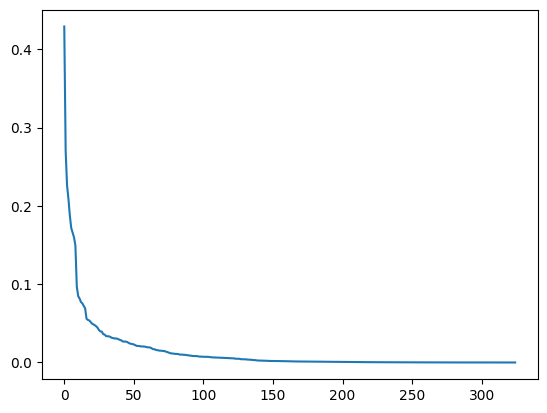

In [24]:
# ingredients frequencies

counts = ingredients_matrix.sum(axis = 0)
freq = counts / ingredients_matrix.shape[0]

freq_list = sorted(freq.tolist(), reverse=True)
sns.lineplot(freq_list[:500])

In [26]:
# get most common ingredients by frequency

ingredients_with_freq = list(zip(freq.tolist(), mlb.classes_))
ingredients_with_freq = sorted(ingredients_with_freq, reverse=True)
ingredients_with_freq[:10]

[(0.429295, 'salt'),
 (0.27013, 'sugar'),
 (0.226245, 'butter'),
 (0.209095, 'flour'),
 (0.1878, 'eggs'),
 (0.171865, 'onion'),
 (0.165615, 'garlic'),
 (0.159865, 'milk'),
 (0.149325, 'water'),
 (0.09719, 'olive oil')]

In [31]:
# compare ingredients in recipe df and the ingredients matrix
#
# the ingredients matrix is a subset of ingredients

print(df['title'][0])
print(df['ingredients'][0])
row = ingredients_df.iloc[0]
print(row[row == True].index.tolist())

print()

print(df['title'][10])
print(df['ingredients'][10])
row = ingredients_df.iloc[10]
print(row[row == True].index.tolist())

print()

print(df['title'][30])
print(df['ingredients'][30])
row = ingredients_df.iloc[30]
print(row[row == True].index.tolist())

Moist Hash Brown Casserole
sour cream|cream of chicken|cheddar cheese|onion|milk|salt
['cheddar cheese', 'milk', 'onion', 'salt', 'sour cream']

Raspberry Crumble Bars
egg|sugar|lemon juice|granulated sugar|light brown sugar|flour|raspberry preserves|raspberries|rolled oats|butter|salt
['butter', 'egg', 'flour', 'lemon juice', 'salt', 'sugar']

Orange Julius
cubes ice|sugar|vanilla|water|orange juice|milk
['milk', 'orange juice', 'sugar', 'water']


In [32]:
# save to drive

name = drive_data / "ingredients.csv"
ingredients_df.to_csv(name)